In [1]:
import pandas as pd
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold

from sklearn.impute import SimpleImputer

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import PowerTransformer

Загрузим обучающий и тестовый сет.

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

Посмотрим на размерность данных и подробнее рассмотрим типы столбцов.

In [3]:
print(f"Размер training set: {train.shape}\n")
print(f"Размер test set: {test.shape}\n")

Размер training set: (1460, 81)

Размер test set: (1459, 80)



In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Удалим из сетов столбец Id.

In [5]:
list_id_train = train['Id']
list_id_test = test['Id']

train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

Изучим данные по столбцам. Для этого построим графики распределения числовых данных по столбцам. 

## Числовые признаки

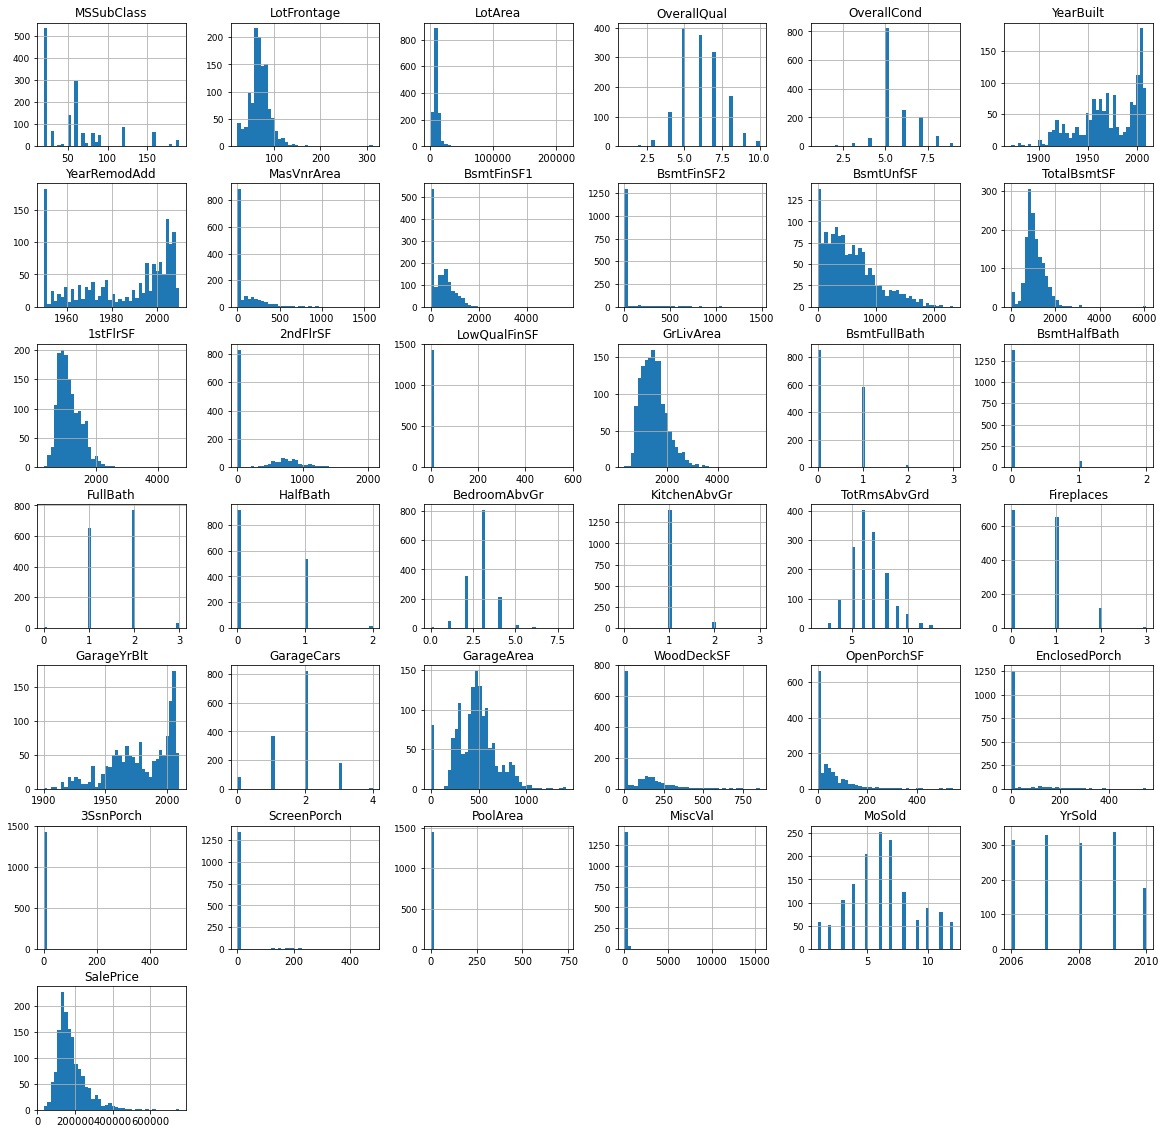

In [6]:
fig_train = train.hist(figsize=(20, 20), bins=40, xlabelsize=10, ylabelsize=9)

Рассмотрим непрерывные переменные. Заметим, что некоторые признаки имеют очень низкую вариацию. Такие признаки можно удалить из обучающего сета, так как скорее всего они не окажут существенного влияния на обучение моделей.

Отберем все непрерывные переменные. Зтем удалим все признаки из обучающего сета, которые имеют вариацию не менее 90%.

In [7]:
numerical_cols = [name for name in train.columns if train[name].dtype in ['int64', 'float64']]
train_nums = train[numerical_cols].copy()
selector = VarianceThreshold(threshold=0.1)
selector.fit(train_nums.iloc[:, :-1])

constant_features_list = [x for x in train_nums.iloc[:, :-1].columns if x not in train_nums.iloc[:, :-1].columns[selector.get_support()]]

print(f"\n Слабоизменяемые признаки: {constant_features_list}")


 Слабоизменяемые признаки: ['BsmtHalfBath', 'KitchenAbvGr']


Удалим признаки 'BsmtHalfBath', 'KitchenAbvGr' из обучающей и тестовой выборок.

In [8]:
train_nums.drop(constant_features_list, axis=1, inplace=True)
train.drop(constant_features_list, axis=1, inplace=True)
test.drop(constant_features_list, axis=1, inplace=True)

In [9]:
print(f"Размер training set с непрерывными переменными: {train_nums.shape}\n")
print(f"Размер training set: {train.shape}\n")

Размер training set с непрерывными переменными: (1460, 35)

Размер training set: (1460, 78)



Посмотрим на корреляцию непрерывных переменных в обучающем наборе. Сильно коррелирующие данные могут привести к переобучению модели.

<AxesSubplot:>

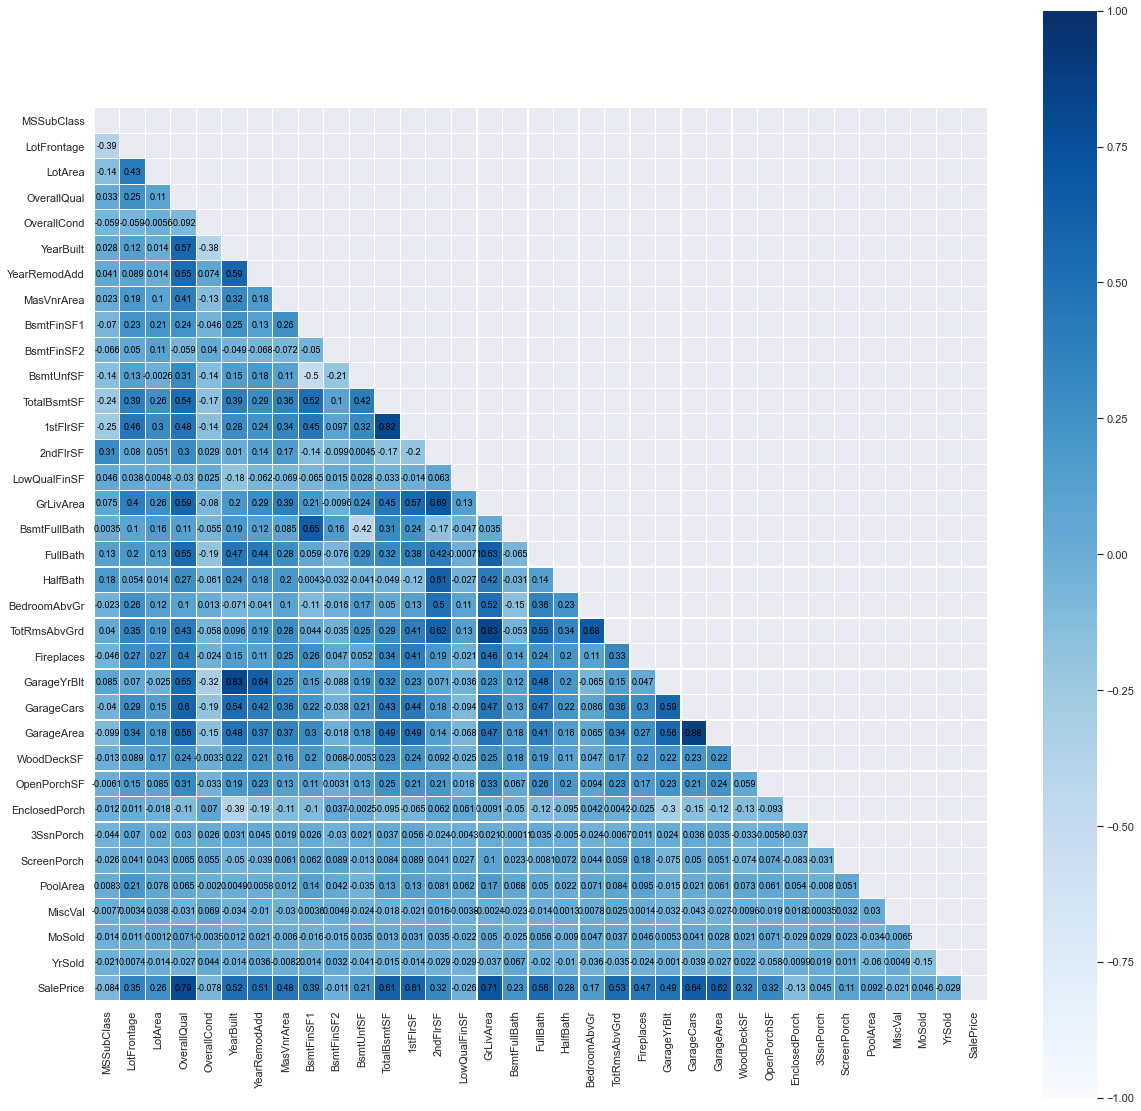

In [10]:
pd.options.display.float_format = "{:,.2f}".format

corr_matrix = train_nums.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.set(rc = {'figure.figsize':(20, 20)})
sns.heatmap(corr_matrix,  vmax=1.0, vmin=-1.0, 
            linewidths=0.1, annot_kws={"size": 9, "color": "black"}, mask=mask, cmap="Blues", square=True, annot=True)

Заметим, что есть ряд сильно коррелирующих признаков, поэтому рассмотрим признаки подробнее. Найдем признаки с выскокой (больше 0.6) и очень низкой (меньше 0.2) корреляцией.

In [11]:
data_num_corr = train_nums.corr()["SalePrice"][:-1]

high_features_list = data_num_corr[abs(data_num_corr) > 0.6].sort_values(ascending=False)
print(f"{len(high_features_list)} признаков с высокой корреляцией:\n{high_features_list}\n")

low_features_list = data_num_corr[abs(data_num_corr) < 0.2].sort_values(ascending=False)
print(f"{len(low_features_list)} признаков со очень низкой корреляцией:\n{low_features_list}")

6 признаков с высокой корреляцией:
OverallQual   0.79
GrLivArea     0.71
GarageCars    0.64
GarageArea    0.62
TotalBsmtSF   0.61
1stFlrSF      0.61
Name: SalePrice, dtype: float64

12 признаков со очень низкой корреляцией:
BedroomAbvGr     0.17
ScreenPorch      0.11
PoolArea         0.09
MoSold           0.05
3SsnPorch        0.04
BsmtFinSF2      -0.01
MiscVal         -0.02
LowQualFinSF    -0.03
YrSold          -0.03
OverallCond     -0.08
MSSubClass      -0.08
EnclosedPorch   -0.13
Name: SalePrice, dtype: float64


Удалим из обучающией выборки признаки с очень низкой корреляцией.

In [12]:
train.drop(low_features_list.index, axis=1, inplace=True)
train_nums.drop(low_features_list.index, axis=1, inplace=True)

Подробнее рассмотрим признаки с высокой корреляцией с целевой переменной.

<AxesSubplot:>

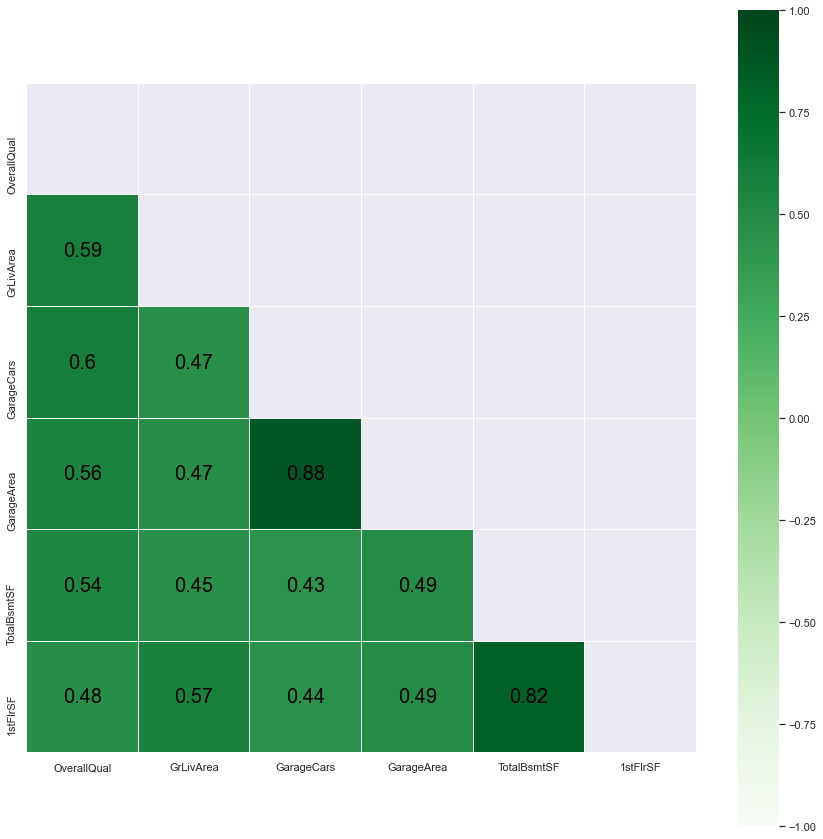

In [13]:
train_nums_high_features = train_nums[high_features_list.index]
corr_matrix = train_nums_high_features.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.set(rc = {'figure.figsize':(15, 15)})
sns.heatmap(corr_matrix,  vmax=1.0, vmin=-1.0, 
            linewidths=0.1, annot_kws={"size": 20, "color": "black"}, mask=mask, cmap="Greens", square=True, annot=True)

Заметим, что признаки "GarageArea" и "GarageCars" сильно коррелируют. Удалим один из признаков из обучающей выборки.

In [14]:
train.drop('GarageArea', axis=1, inplace=True)
train_nums.drop('GarageArea', axis=1, inplace=True)

Рассмотрим данные на пропущенные значения.

Столбцы с пропущенными значениями: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


Text(0, 0.5, 'Признак\n')

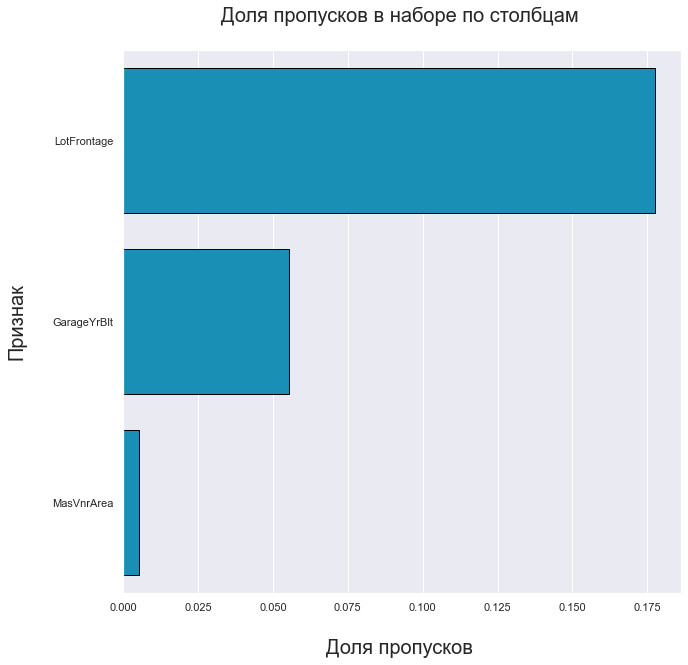

In [15]:
columns_with_missing_values = [col for col in train_nums.columns
                     if train_nums[col].isnull().any()]

print(f"Столбцы с пропущенными значениями: {columns_with_missing_values}")

cols_nan_count = list(map(lambda col: train_nums[col].isna().sum()/len(train_nums), columns_with_missing_values))


tab = pd.DataFrame(columns_with_missing_values, columns=["Column"])
tab["Percent_NaN"] = cols_nan_count
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)

sns.set(rc={"figure.figsize": (10, 10)})

p = sns.barplot(x="Percent_NaN", y="Column", data=tab, edgecolor="black", color="#009cd0")

p.set_title("Доля пропусков в наборе по столбцам \n", fontsize=20)
p.set_xlabel("\nДоля пропусков ", fontsize=20)
p.set_ylabel("Признак\n", fontsize=20)

Три признака ('LotFrontage', 'MasVnrArea', 'GarageYrBlt') имеют пропущенные значения. Попробуем заменить их на медианные значения и посмотрим, как изменится их распределение.

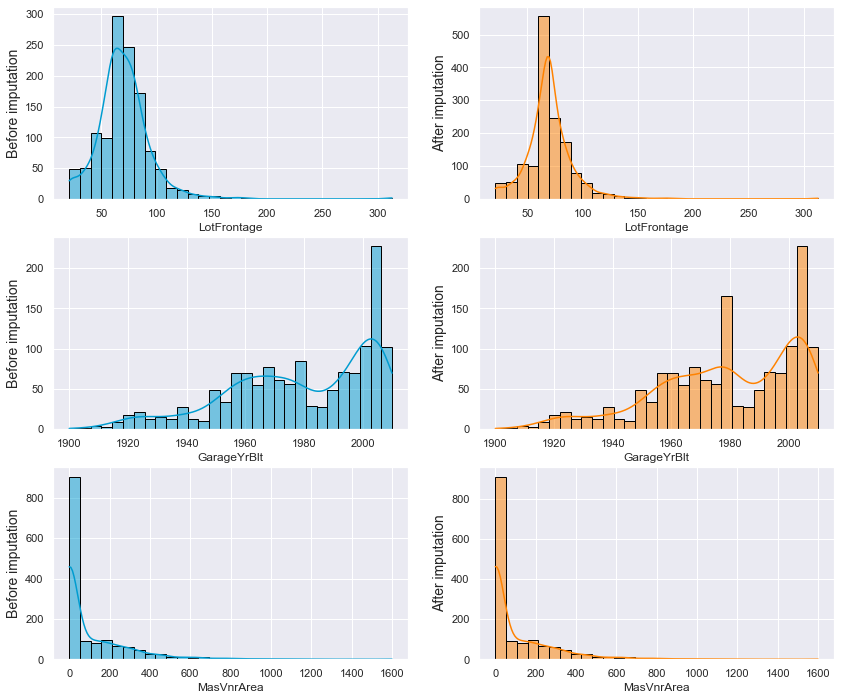

In [16]:
imputer = SimpleImputer(strategy="median")
train_imputed = pd.DataFrame(imputer.fit_transform(train_nums))
train_imputed.columns = train_nums.columns

sns.set(rc={"figure.figsize": (14, 12)})
fig, axes = plt.subplots(3, 2)

for feature, fig_pos in zip(["LotFrontage", "GarageYrBlt", "MasVnrArea"], [0, 1, 2]):

    # до замены
    p = sns.histplot(ax=axes[fig_pos, 0], x=train_nums[feature], kde=True, bins=30, color="#009cd0", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # после замены
    q = sns.histplot(ax=axes[fig_pos, 1], x=train_imputed[feature], kde=True, bins=30, color="#ff8200", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

Заметим, что переменная "LotFrontage" имеет сильное смещение после замены пропущенных значений в сторону медианных значений.
Распределение признака "GarageYrBlt" также немного изменилось (резко выросло число 1980-х годов). Распределение изменилось несильно. Однако смысл значения признака для пропущенных сильно искажается. Поэтому лучше удалим данный признак перед обучением.
Распределение признака "MasVnrArea", согласно полученному графику, сильно не изменилось. Заменим данный столбец, заменив пропуски на медианные значения.

In [17]:
train.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)
train_nums.drop(["LotFrontage", "GarageYrBlt"], axis=1, inplace=True)

In [18]:
train_nums = train_nums.fillna(train_nums['MasVnrArea'].median())

Изучим количественные признаки на выбросы.

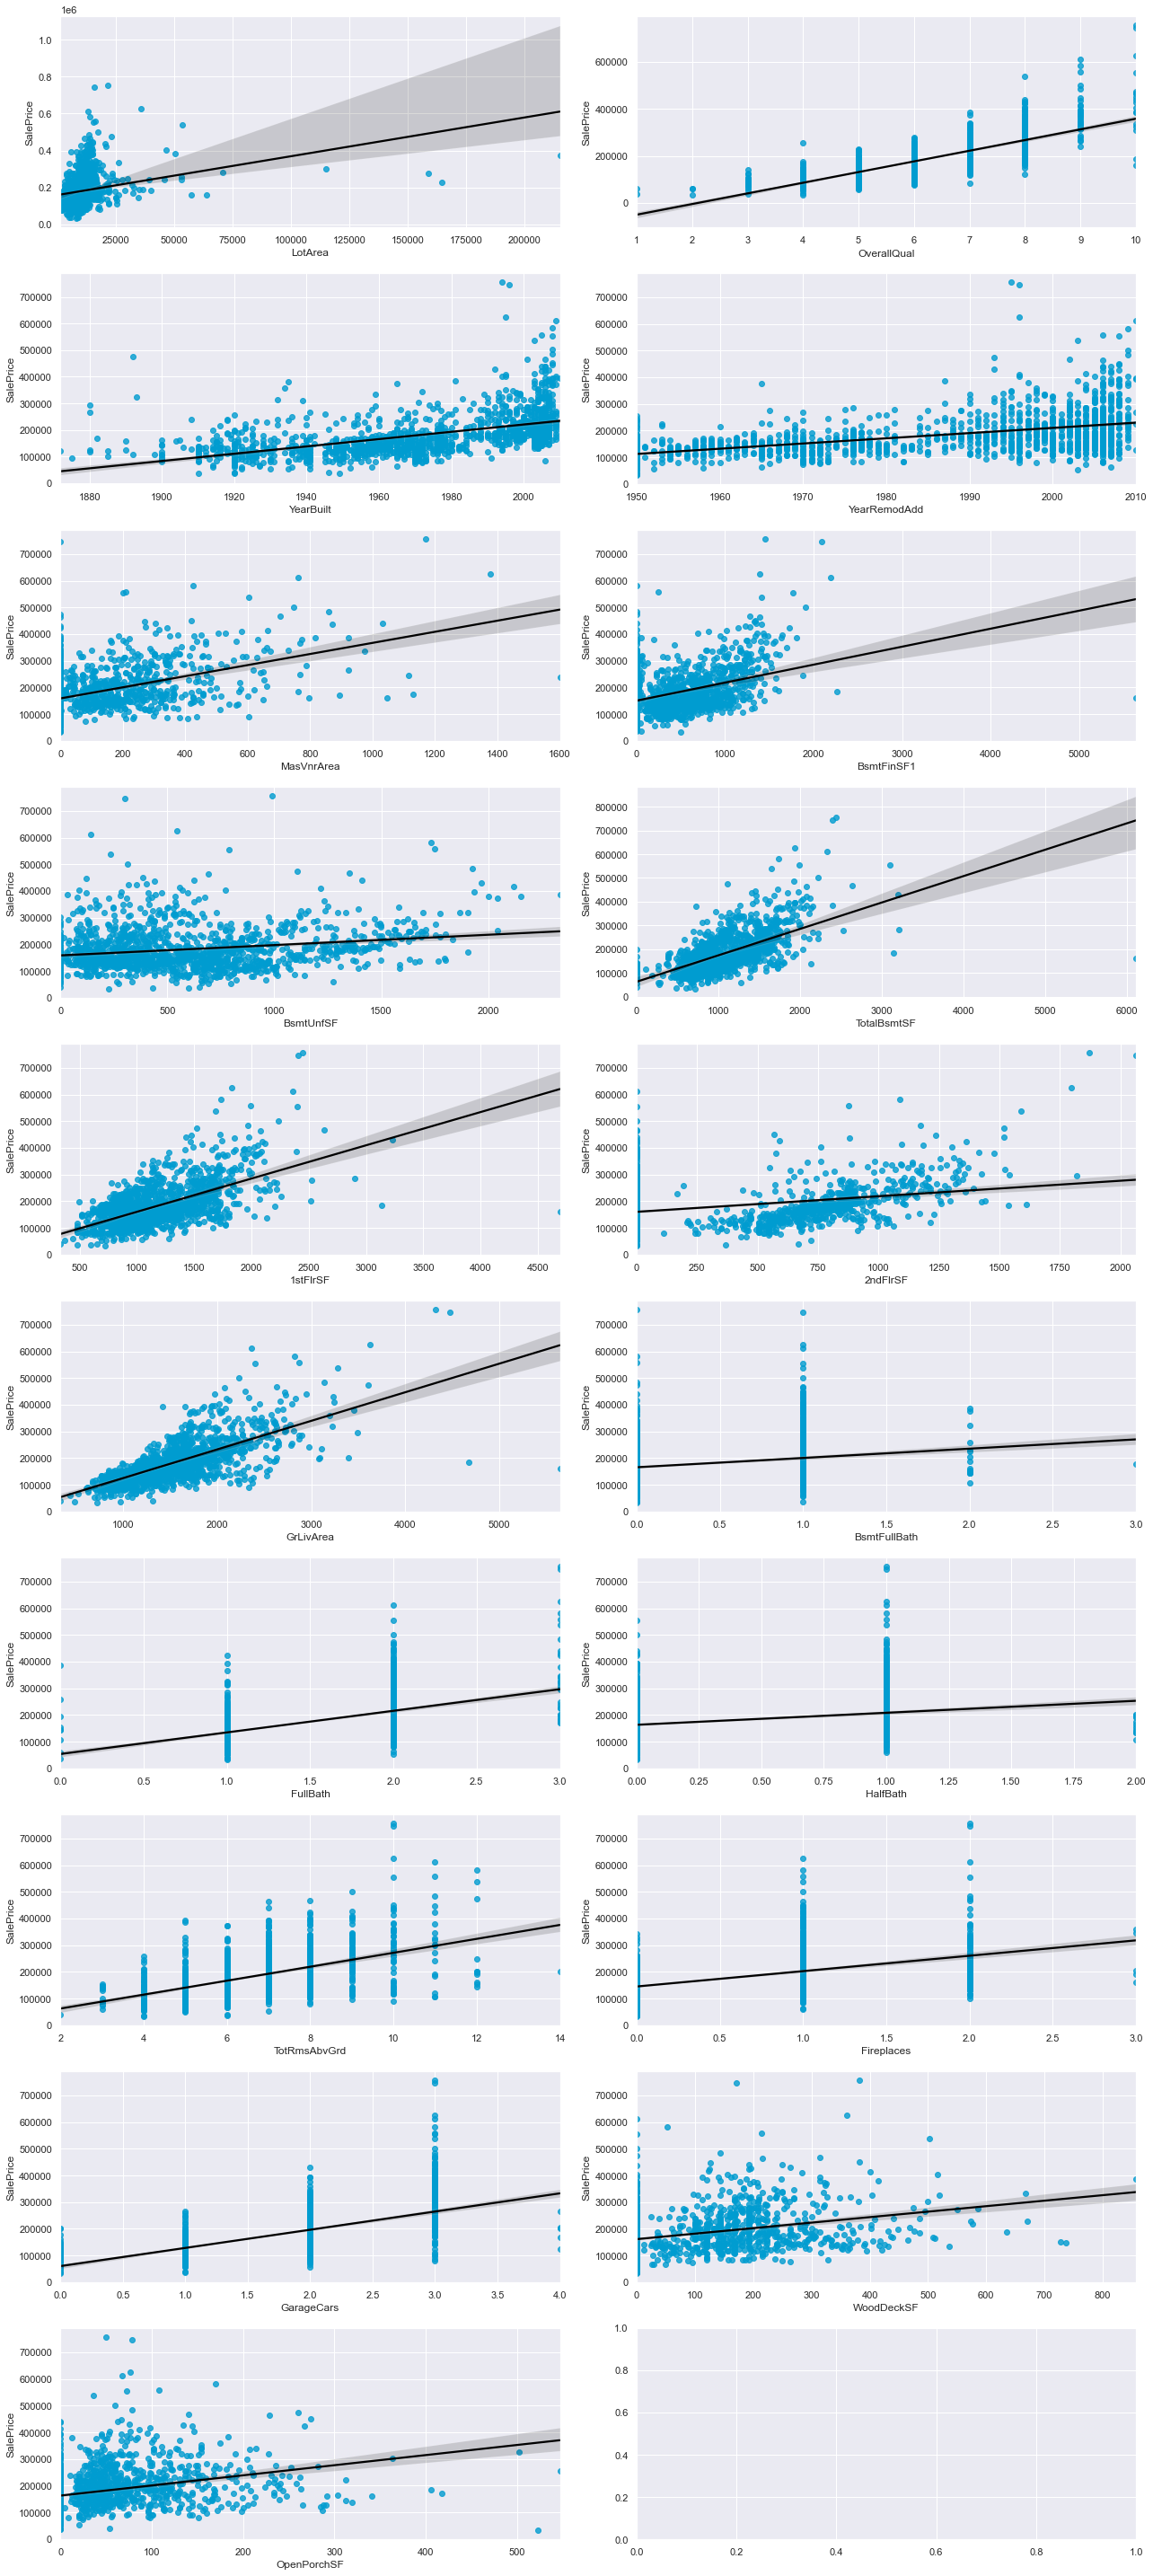

In [19]:
fig, ax = plt.subplots(round(len(train_nums.columns) / 2), 2)
fig.set_size_inches(18,40)

for i, ax in enumerate(fig.axes):
    if i < len(train_nums.columns) - 1:
        sns.regplot(x=train_nums.columns[i], y="SalePrice", data=train_nums, ax=ax, 
                    scatter_kws={"color": "#009cd0"}, line_kws={"color": "black"},)
fig.tight_layout()

Заметим наличие выбросов. Воспользуемся стандартной оценкой (Z score).

In [20]:
list_outer_rows = list()

for i in train_nums.columns:
 
    z = np.abs(stats.zscore(train_nums[i]))
    threshold = 2.58
    #p=0.01
    list_outer_rows += list(*np.where(z > threshold))

list_outer_rows = list(set(list_outer_rows))

print(list_outer_rows)
print(f"\n{len(list_outer_rows)} строк для удаления (выбросы) \n")


[1024, 515, 517, 1031, 523, 524, 11, 527, 529, 1044, 533, 22, 1046, 20, 25, 538, 540, 28, 35, 37, 552, 1068, 1076, 53, 566, 58, 64, 66, 581, 70, 583, 1100, 588, 78, 591, 80, 1106, 597, 1111, 87, 605, 607, 608, 104, 105, 106, 618, 1132, 1130, 621, 624, 1137, 113, 115, 628, 1141, 630, 118, 1142, 634, 635, 636, 641, 1154, 642, 645, 137, 1163, 654, 1169, 661, 1173, 1175, 664, 666, 1181, 1182, 1184, 161, 674, 678, 166, 1190, 169, 1193, 172, 686, 176, 688, 178, 691, 1203, 1205, 183, 185, 1210, 700, 188, 1213, 706, 197, 713, 1227, 716, 1228, 718, 1230, 1243, 1245, 735, 224, 738, 231, 745, 747, 235, 238, 755, 1268, 1267, 1270, 249, 763, 768, 769, 1283, 774, 1287, 775, 1289, 1292, 271, 784, 1298, 278, 798, 1312, 1313, 803, 293, 1318, 807, 808, 297, 298, 809, 1324, 1317, 302, 304, 1328, 309, 313, 825, 1340, 828, 320, 324, 1349, 326, 1350, 1353, 843, 332, 1355, 844, 335, 848, 1360, 854, 343, 1369, 860, 1373, 349, 350, 357, 362, 1386, 875, 1396, 375, 888, 377, 378, 893, 384, 897, 898, 389, 1416, 1

Удалим строки с выбросами из обучающего набора. 

In [21]:
train_nums.drop(list_outer_rows, inplace = True)
train.drop(list_outer_rows, inplace = True)

In [22]:
print(f"Training set shape with numerical features: {train_nums.shape}\n")
print(f"Training set shape: {train.shape}\n")

Training set shape with numerical features: (1229, 20)

Training set shape: (1229, 63)



## Категориальные признаки

Перейдем к рассмотрению категориальных признаков.

In [23]:
categorical_cols = [i for i in train.columns if train.dtypes[i] == "object"]
categorical_cols.append("SalePrice")

train_categorical = train[categorical_cols].copy()

In [24]:
train_categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,208500
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,181500
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,223500
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,140000
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,250000


In [25]:
train_categorical.shape

(1229, 44)

Посмотрим подробнее на категориальные признаки.

<ipython-input-26-98da455c18b6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
<ipython-input-26-98da455c18b6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
<ipython-input-26-98da455c18b6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
<ipython-input-26-98da455c18b6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
<ipython-input-26-98da455c18b6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
<ipython-input-26-98da455c18b6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_x

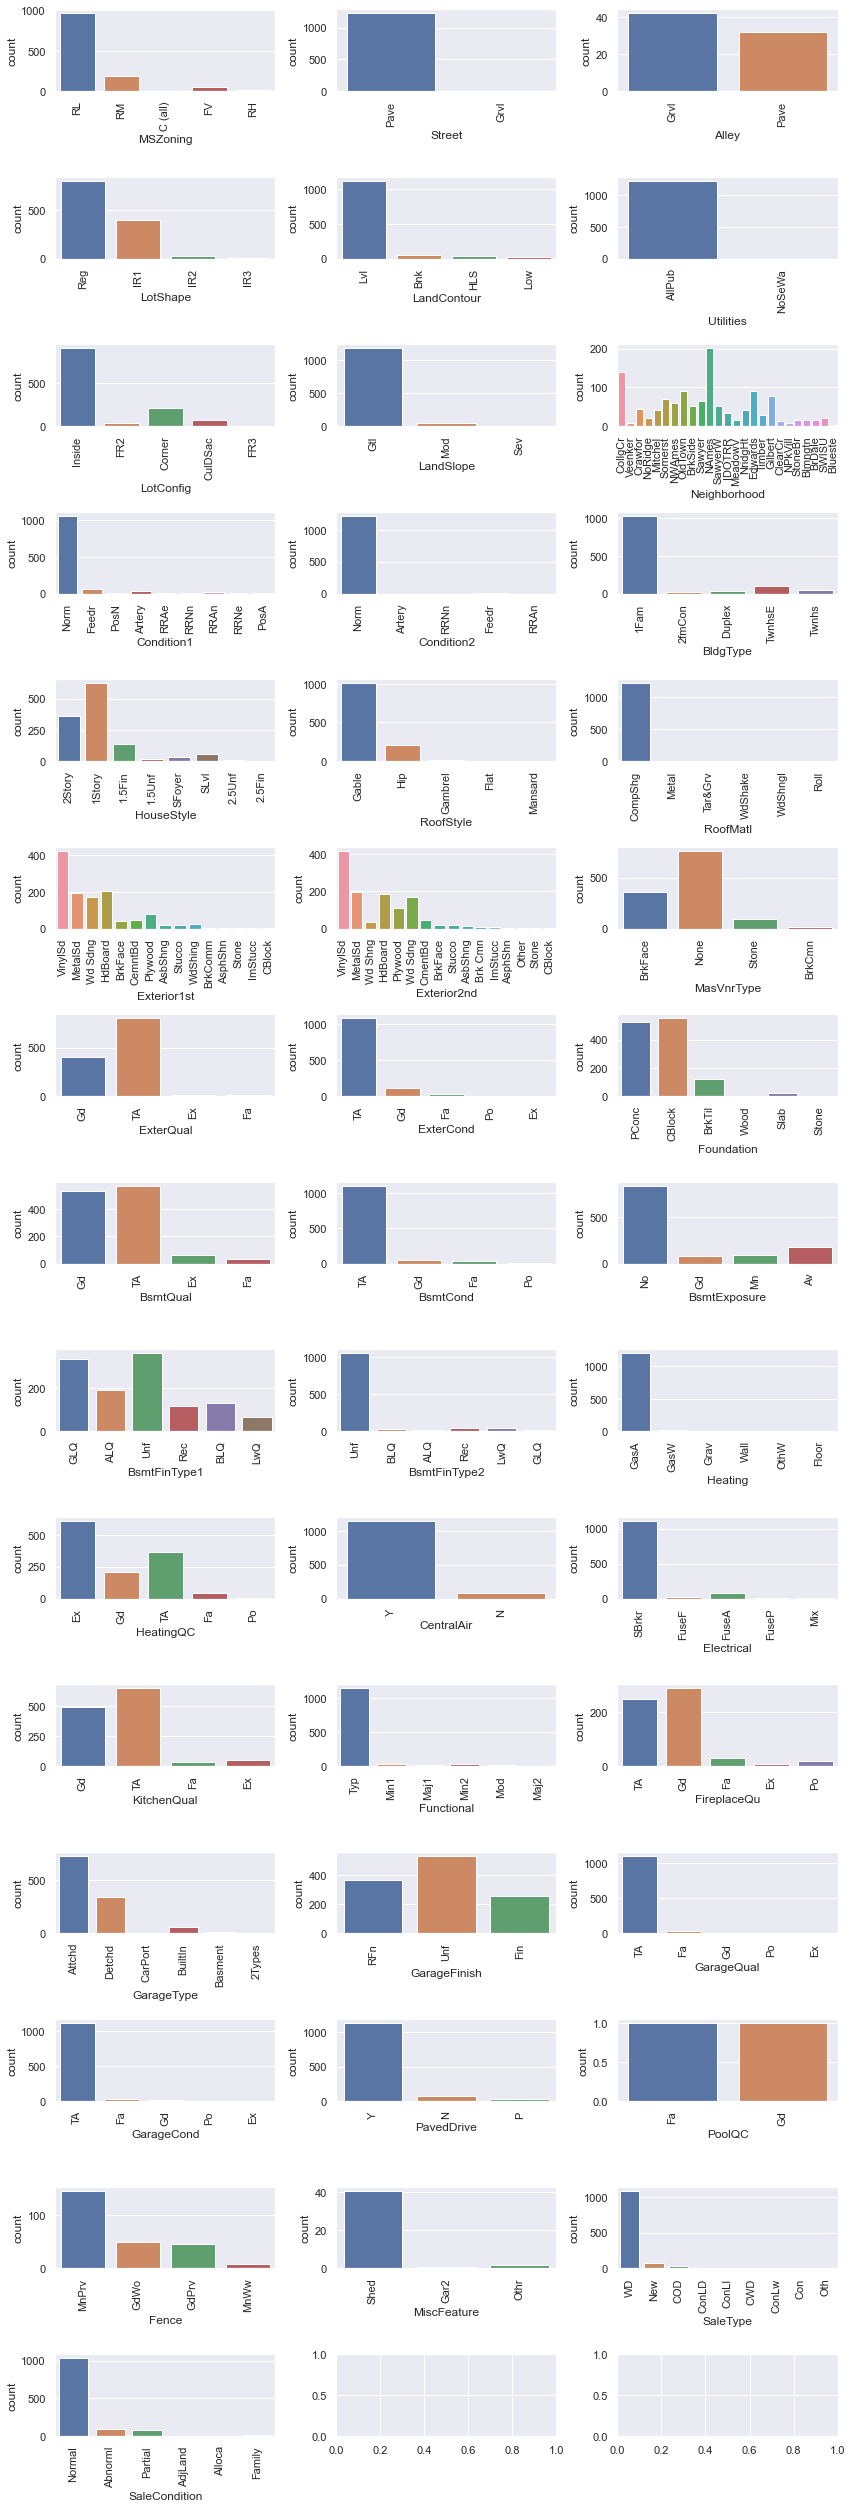

In [26]:
fig, axes = plt.subplots(round(len(train_categorical.columns) / 3), 3, figsize=(12, 35))

for i, ax in enumerate(fig.axes):
    if i < len(train_categorical.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=train_categorical.columns[i], data=train_categorical, ax=ax)

fig.tight_layout()

In [27]:
train_categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,208500
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,181500
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,223500
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,140000
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,250000


Посмотрим на распределение категориальных признаков.

In [28]:
for i in train_categorical.columns:
    print(train_categorical.groupby(i)[i].count())

MSZoning
C (all)      8
FV          53
RH          14
RL         964
RM         190
Name: MSZoning, dtype: int64
Street
Grvl       4
Pave    1225
Name: Street, dtype: int64
Alley
Grvl    42
Pave    32
Name: Alley, dtype: int64
LotShape
IR1    397
IR2     28
IR3      8
Reg    796
Name: LotShape, dtype: int64
LandContour
Bnk      51
HLS      42
Low      20
Lvl    1116
Name: LandContour, dtype: int64
Utilities
AllPub    1228
NoSeWa       1
Name: Utilities, dtype: int64
LotConfig
Corner     212
CulDSac     73
FR2         40
FR3          4
Inside     900
Name: LotConfig, dtype: int64
LandSlope
Gtl    1176
Mod      51
Sev       2
Name: LandSlope, dtype: int64
Neighborhood
Blmngtn     16
Blueste      2
BrDale      15
BrkSide     53
ClearCr     14
CollgCr    140
Crawfor     44
Edwards     90
Gilbert     79
IDOTRR      34
MeadowV     15
Mitchel     41
NAmes      201
NPkVill      9
NWAmes      59
NoRidge     22
NridgHt     41
OldTown     92
SWISU       20
Sawyer      66
SawyerW     52
Somerst   

Найдем признаки, в которых доля чаще встречаемого значения больше 80%.

In [29]:
list_cat_columns = list()

for i in train_categorical.columns:
    list_cat_columns.append(train_categorical.groupby(i)[i].count().max())
    
sup_table = pd.DataFrame({'feature': train_categorical.columns, 'max_value': list_cat_columns})
sup_table['ratio'] = sup_table.max_value / train_categorical.shape[0]
sup_table['needed']  = sup_table.ratio < 0.8

In [30]:
sup_table.head()

,feature,max_value,ratio,needed
0,MSZoning,964,0.78,True
1,Street,1225,1.00,False
2,Alley,42,0.03,True
3,LotShape,796,0.65,True
4,LandContour,1116,0.91,False


In [31]:
del_columns = list(sup_table[sup_table.needed == False].feature)

In [32]:
print(f'Категориальные признаки, в которых одно значение встречается как минимум в 80% случаях:\n{del_columns}')

Категориальные признаки, в которых одно значение встречается как минимум в 80% случаях:
['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


Удалим данные столбцы.

In [34]:
train_categorical.drop(del_columns, axis=1, inplace=True)
test.drop(del_columns, axis=1, inplace=True)

Проверим категориальные признаки на пустые значения.

Text(0, 0.5, 'Названия колонок\n')

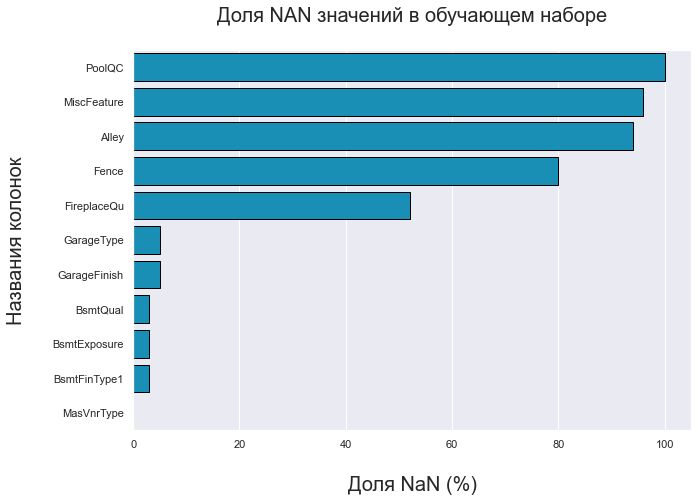

In [35]:
cat_cols_with_missing = [col for col in train_categorical.columns if train_categorical[col].isnull().any()]

cat_cols_nan_count = list(map(lambda col: round(train_categorical[col].isna().sum()*100/len(train_categorical)), 
                              cat_cols_with_missing))


tab_cat = pd.DataFrame(cat_cols_with_missing, columns=["Column"])
tab_cat["Percent_NaN"] = cat_cols_nan_count
tab_cat.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)

sns.set(rc={"figure.figsize": (10, 7)})

p = sns.barplot(x="Percent_NaN", y="Column", data=tab_cat, edgecolor="black", color="#009cd0")

p.set_title("Доля NAN значений в обучающем наборе\n", fontsize=20)
p.set_xlabel("\nДоля NaN (%)", fontsize=20)
p.set_ylabel("Названия колонок\n", fontsize=20)

Выберем колонки с большим количеством пропущенных значений (больше 20%) и остальные. Удалим признаки с большим количеством пропусков.

In [36]:
large_na = [col for col in cat_cols_with_missing if (train_categorical[col].isna().sum()/train_categorical.shape[0]) > 0.2]
large_not_na = [col for col in cat_cols_with_missing if (train_categorical[col].isna().sum()/train_categorical.shape[0]) <= 0.2]

train_categorical.drop(large_na, axis=1, inplace=True)
test.drop(large_na, axis=1, inplace=True)

In [37]:
print(f"Train набор с категориальными признаками: {train_categorical.shape}\n")
print(f"Train набор: {train.shape}\n")

Train набор с категориальными признаками: (1229, 18)

Train набор: (1229, 63)



Заполним пропуски в оставшихся признаках модальными значениями.

In [38]:
categ_fill_null = {}
for i in large_not_na:
    categ_fill_null[i] = train_categorical[i].mode().iloc[0]

train_categorical = train_categorical.fillna(value=categ_fill_null)

Рассмотрим изменение целевой переменной для каждого категориального признака.

<ipython-input-39-33b16e98e1f2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
<ipython-input-39-33b16e98e1f2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
<ipython-input-39-33b16e98e1f2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
<ipython-input-39-33b16e98e1f2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
<ipython-input-39-33b16e98e1f2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
<ipython-input-39-33b16e98e1f2>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_x

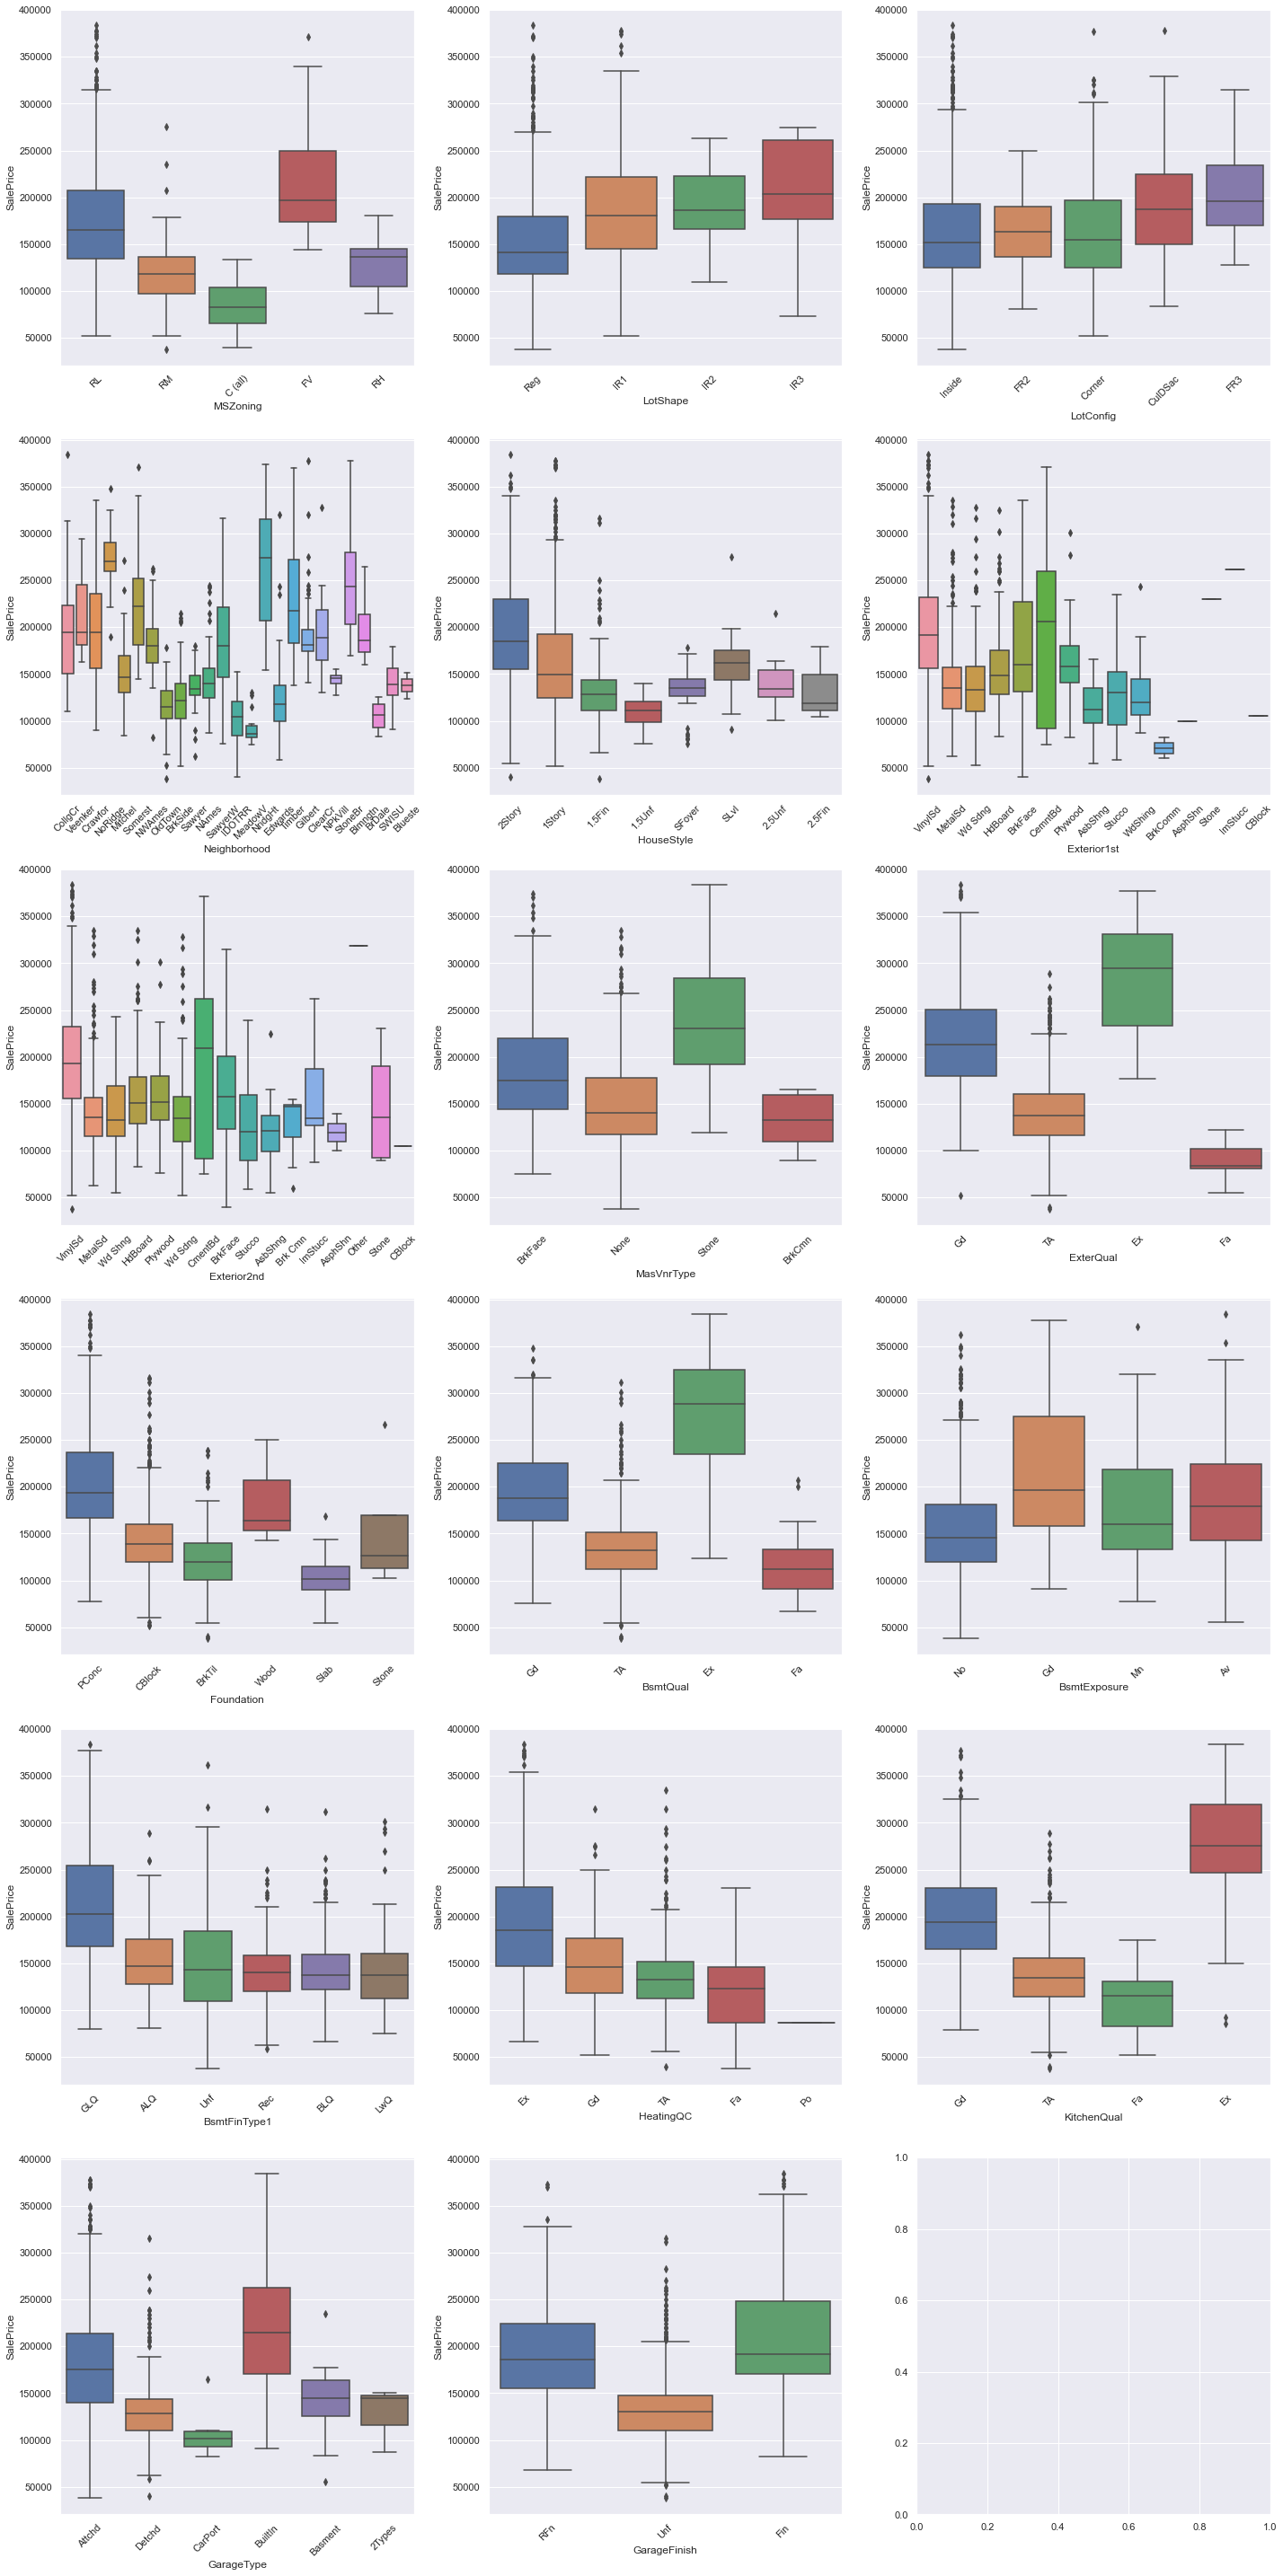

In [39]:
fig, axes = plt.subplots(round(len(train_categorical.columns)/3), 3, figsize=(20, 40))

for i, ax in enumerate(fig.axes):
    if i < len(train_categorical.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.boxplot(x=train_categorical.columns[i], y="SalePrice", data=train_categorical, ax=ax)

fig.tight_layout()

По графикам есть несколько признаков с очень похожим распределением по целевому признаку SalePrices: "Exterior1st" и "Exterior2nd", "MasVnrType" и "ExterQual". Проверим зависимость между указанными признаками при помощи критерия Пирсона (хи-квадрат). За уровень значимости возьмем 5%.

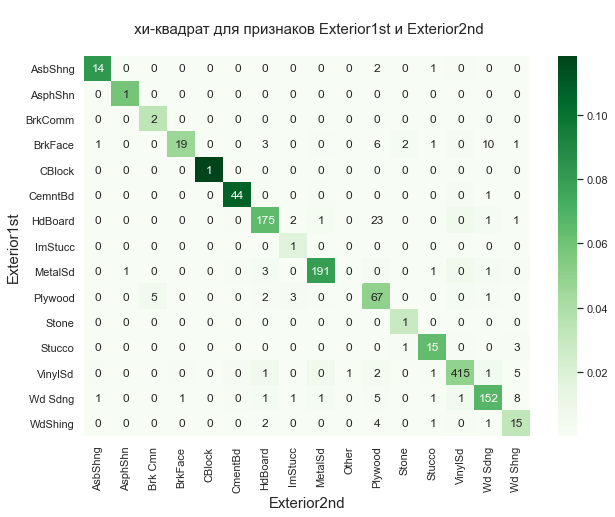

p-value для признаков Exterior1st и Exterior2nd равно: 0.0

alpha=0.050000, p=0.000000
Зависимость есть (отклоняем нулевую гипотезу)


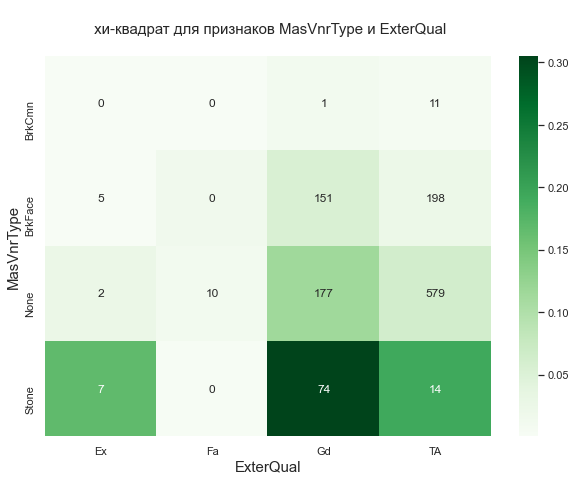

p-value для признаков MasVnrType и ExterQual равно: 9.469365322677554e-37

alpha=0.050000, p=0.000000
Зависимость есть (отклоняем нулевую гипотезу)


In [40]:
sns.set(rc={"figure.figsize": (10, 7)})

X = ["Exterior1st", "MasVnrType"]
Y = ["Exterior2nd", "ExterQual"]

alpha = 0.05

for i, j in zip(X, Y):
    cont = train_categorical[[i, j]].pivot_table(index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(train_categorical)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    p = sns.heatmap(table.iloc[:-1, :-1], annot=c.iloc[:-1, :-1], fmt=".0f", cmap="Greens")
    p.set_xlabel(j, fontsize=15)
    p.set_ylabel(i, fontsize=15)
    p.set_title(f"\n хи-квадрат для признаков {i} и {j}\n", size=15)
    plt.show()

    cross_table = pd.crosstab(index=train_categorical[i], columns=train_categorical[j])
    chi_sq_result = chi2_contingency(cross_table)
    
    print(f"p-value для признаков {i} и {j} равно: {chi_sq_result[1]}\n")
    print('alpha=%.6f, p=%.6f' % (alpha, chi_sq_result[1]))
    if chi_sq_result[1] <= alpha:
        print('Зависимость есть (отклоняем нулевую гипотезу)')
    else:
        print('Независимы (принимаем нулевую гипотезу)')

Получили, что признаки "Exterior1st" и "Exterior2nd", "MasVnrType" и "ExterQual" сильно зависимы. Удалим один из каждой пары из выборки.

In [41]:
train_categorical.drop(Y, axis=1, inplace=True)
train.drop(Y, axis=1, inplace=True)

In [42]:
print(f"Train набор с категориальными признаками: {train_categorical.shape}\n")
print(f"Train набор: {train.shape}\n")

Train набор с категориальными признаками: (1229, 16)

Train набор: (1229, 61)



Прежде чем мы объединим категориальные данные обратно с числовыми данными, нам нужно преобразовать категориальные записи в числовые записи. Это будет сделано с помощью функции get_dummies(), где каждый категориальный объект будет преобразован в двоичный объект.

In [43]:
#train_categorical.drop(["SalePrice"], axis = 1, inplace = True)

data_train_dummies = pd.get_dummies(train_categorical)
data_train_dummies.head()

,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,KitchenQual_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,208500,0,0,0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,181500,0,0,0,1,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0
2,223500,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
3,140000,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,250000,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0


## Распределение непрерывных признаков

Вернемся к рассмотрению непрерывных признаков и их распределениям. Проверим, требуется ли для них нормализация. 

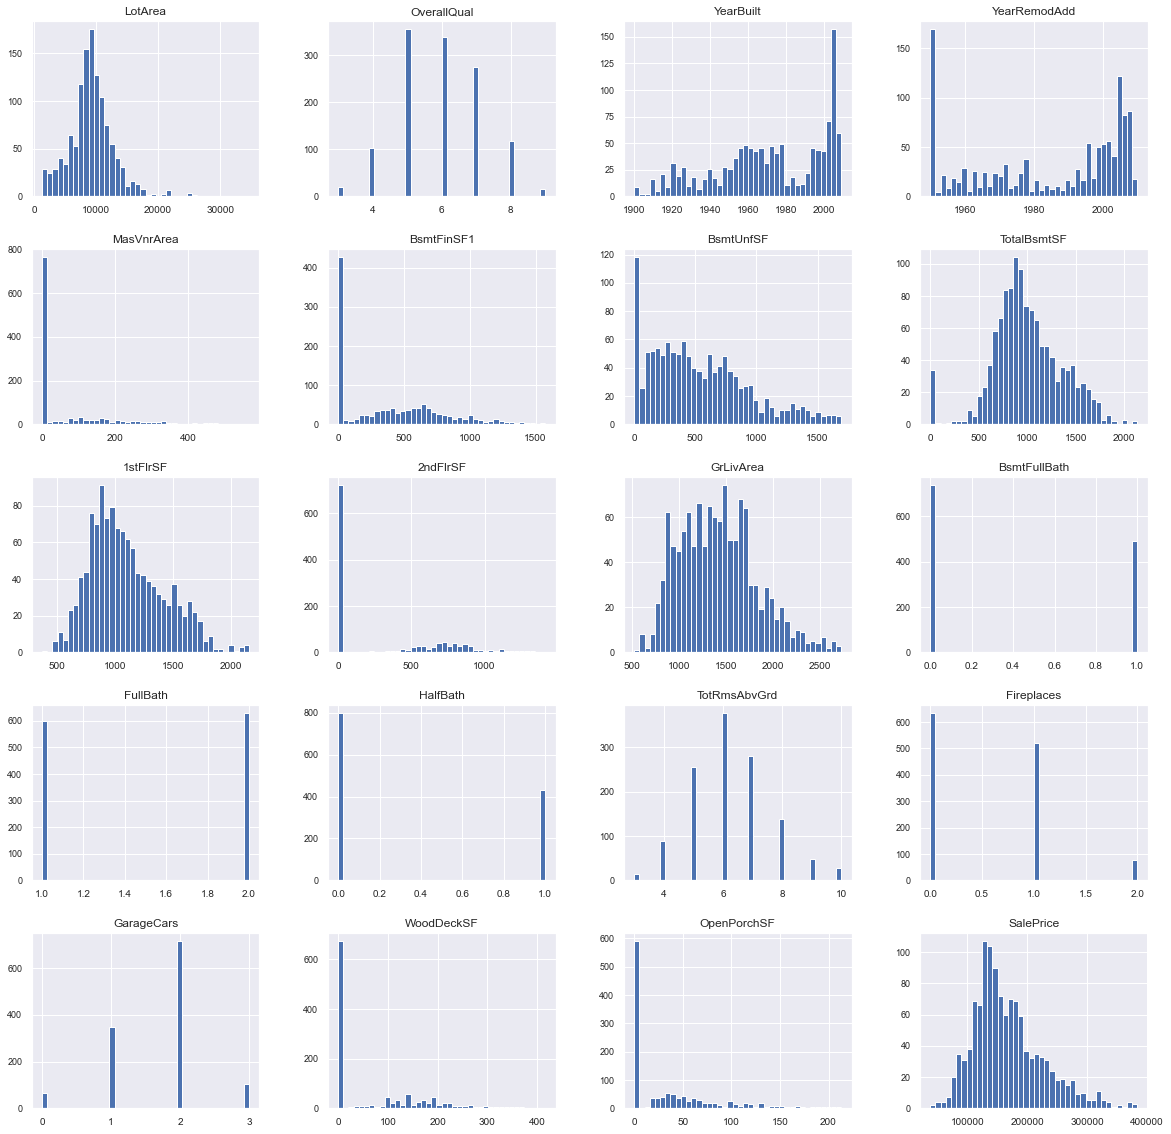

In [44]:
fig_train = train.hist(figsize=(20, 20), bins=40, xlabelsize=10, ylabelsize=9)

Для признаков 'LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea','WoodDeckSF', 'OpenPorchSF' требуется нормализация. 

In [45]:
continuous_features = ['LotArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
                       'WoodDeckSF', 'OpenPorchSF']

In [46]:
for i in continuous_features:
    train_nums[i] = np.log((train_nums[i])+1)
    test[i] = np.log((test[i])+1)

## Подготовка train set

Соберем все обработанные данные в train set.

In [47]:
print(train_nums.shape)
print(data_train_dummies.shape)

(1229, 20)
(1229, 105)


In [48]:
data_train_dummies.drop(["SalePrice"], axis = 1, inplace = True)

finish_train = train_nums.join(data_train_dummies)

In [49]:
finish_train.head()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,KitchenQual_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
0,9.04,7,2003,2003,196.00,6.56,5.02,6.75,6.75,6.75,...,0,0,1,0,0,0,0,0,1,0
1,9.17,6,1976,1976,0.00,6.89,5.65,7.14,7.14,0.00,...,1,0,1,0,0,0,0,0,1,0
2,9.33,7,2001,2002,162.00,6.19,6.08,6.83,6.83,6.77,...,0,0,1,0,0,0,0,0,1,0
3,9.16,7,1915,1970,0.00,5.38,6.29,6.63,6.87,6.63,...,0,0,0,0,0,0,1,0,0,1
4,9.57,8,2000,2000,350.00,6.49,6.20,7.04,7.04,6.96,...,0,0,1,0,0,0,0,0,1,0


## Подготовка тестовых данных

Подготовим тестовые данные перед обучением согласно подготовленному train setу.

In [50]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,RH,80.00,9.36,Reg,Inside,NAmes,1Story,5,6,...,730.00,4.95,0.00,0,0,120,0,0,6,2010
1,20,RL,81.00,9.57,IR1,Corner,NAmes,1Story,6,6,...,312.00,5.98,3.61,0,0,0,0,12500,6,2010
2,60,RL,74.00,9.53,IR1,Inside,Gilbert,2Story,5,5,...,482.00,5.36,3.56,0,0,0,0,0,3,2010
3,60,RL,78.00,9.21,IR1,Inside,Gilbert,2Story,6,6,...,470.00,5.89,3.61,0,0,0,0,0,6,2010
4,120,RL,43.00,8.52,IR1,Inside,StoneBr,1Story,8,5,...,506.00,0.00,4.42,0,0,144,0,0,1,2010


In [51]:
test_nums_col = list(train_nums.columns)
test_nums_col.remove('SalePrice')
test_nums = test[test_nums_col]

In [52]:
test_nums.shape

(1459, 19)

Проверим тестовые числовые признаки на пропуски.

Столбцы с пропущенными значениями: ['MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'GarageCars']


Text(0, 0.5, 'Признак\n')

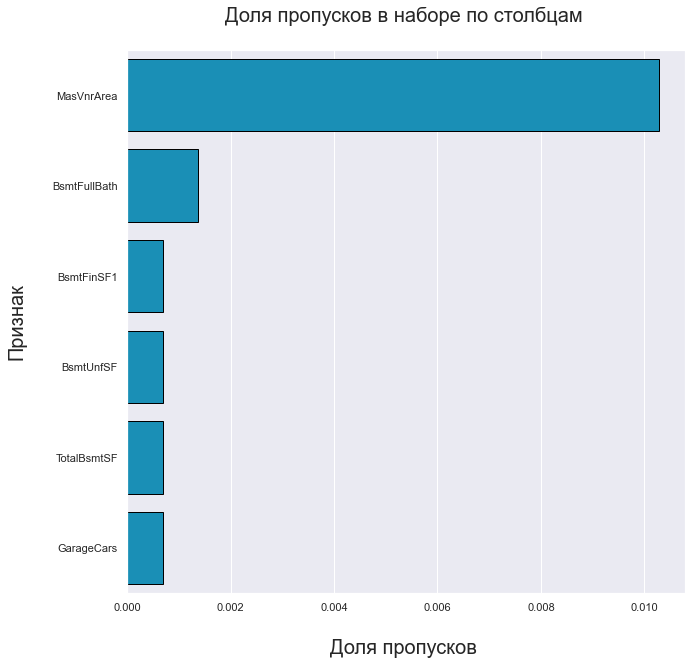

In [53]:
columns_with_missing_values_test = [col for col in test_nums.columns
                     if test_nums[col].isnull().any()]

print(f"Столбцы с пропущенными значениями: {columns_with_missing_values_test}")

cols_nan_count_test = list(map(lambda col: test_nums[col].isna().sum()/len(test_nums), columns_with_missing_values_test))


tab = pd.DataFrame(columns_with_missing_values_test, columns=["Column"])
tab["Percent_NaN"] = cols_nan_count_test
tab.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)

sns.set(rc={"figure.figsize": (10, 10)})

p = sns.barplot(x="Percent_NaN", y="Column", data=tab, edgecolor="black", color="#009cd0")

p.set_title("Доля пропусков в наборе по столбцам \n", fontsize=20)
p.set_xlabel("\nДоля пропусков ", fontsize=20)
p.set_ylabel("Признак\n", fontsize=20)

Заполним пропуски медианными значениями.

In [54]:
for col in columns_with_missing_values_test:
    test_nums = test_nums.fillna(test_nums[i].median())

Перейдем к рассмотрению категориальных признаков в тестовом наборе данных.

In [55]:
sum_test_cat_list = list(train_categorical.columns)

In [56]:
sum_test_cat_list.remove('SalePrice')
print(sum_test_cat_list)

['MSZoning', 'LotShape', 'LotConfig', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'MasVnrType', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish']


In [57]:
test_categorical = test[sum_test_cat_list]

In [58]:
cat_cols_with_missing_test = [col for col in test_categorical.columns if test_categorical[col].isnull().any()]

Проверим категориальные признаки тестового набора на пропуски.

Text(0, 0.5, 'Признаки\n')

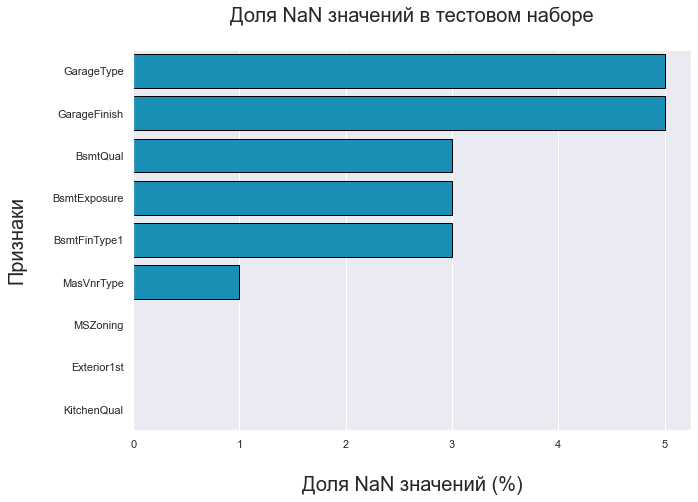

In [59]:
cat_cols_nan_count_test = list(map(lambda col: round(test_categorical[col].isna().sum()*100/len(test_categorical)), 
                              cat_cols_with_missing_test))


tab_cat = pd.DataFrame(cat_cols_with_missing_test, columns=["Column"])
tab_cat["Percent_NaN"] = cat_cols_nan_count_test
tab_cat.sort_values(by=["Percent_NaN"], ascending=False, inplace=True)


sns.set(rc={"figure.figsize": (10, 7)})

p = sns.barplot(x="Percent_NaN", y="Column", data=tab_cat, edgecolor="black", color="#009cd0")

p.set_title("Доля NaN значений в тестовом наборе\n", fontsize=20)
p.set_xlabel("\nДоля NaN значений (%)", fontsize=20)
p.set_ylabel("Признаки\n", fontsize=20)

Заполним пропуски модальными значениями.

In [60]:
categ_fill_null_test = {}
for i in cat_cols_with_missing_test:
    categ_fill_null_test[i] = test_categorical[i].mode().iloc[0]
    
categ_fill_null_test

test_categorical = test_categorical.fillna(value=categ_fill_null_test)

In [63]:
data_test_dummies = pd.get_dummies(test_categorical)
data_test_dummies.shape

(1459, 101)

In [62]:
data_train_dummies.shape

(1229, 104)

Заметим, что у таблиц data_test_dummies и data_train_dummies разные размерности.

In [64]:
col_fill_test = set(data_train_dummies.columns) - set(data_test_dummies.columns)

In [65]:
print(f'Недостающие столбцы: {col_fill_test}')

Недостающие столбцы: {'Exterior1st_ImStucc', 'HouseStyle_2.5Fin', 'Exterior1st_Stone'}


Из отсутсвующих в тестовом наборе признаков присутсвуют все категориальные признаки. Это значит, что в тестовом наборе данные признаки отсутсвуют, поэтому добавим данные столбцы к тестовому набору со значениями 0.

In [66]:
data_test_dummies[list(col_fill_test)] = 0

In [67]:
data_test_dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,Exterior1st_ImStucc,HouseStyle_2.5Fin,Exterior1st_Stone
0,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [68]:
finish_test = test_nums.join(data_test_dummies)

In [69]:
print(f'Размер обучающего набора: {finish_train.shape}')
print(f'Размер тестового набора: {finish_test.shape}')

Размер обучающего набора: (1229, 124)
Размер тестового набора: (1459, 123)


## Моделирование

Подготовим данные для обучения.

In [70]:
X = finish_train.drop(['SalePrice'], axis=1)
y = finish_train['SalePrice']

print(f"X:{X.shape}")
print(f"y:{y.shape}")

X:(1229, 123)
y:(1229,)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")

X_train:(823, 123)
y_train:(823,)

X_test:(406, 123)
y_test:(406,)


Добавим функцию для выведения оценок R² (коэффициент детерминации) и RMSE (среднеквадратическое отклонение).

In [72]:
def print_score(test, pred, type):
    
    print(f'Модель: {type}')
    
    r2 = r2_score(test, pred)
    print(f'R² = {r2}')
    
    rmse = np.sqrt(mean_squared_error(test, pred))
    print(f'RMSE = {rmse}')
    
    return

Начнем с линейной регрессии.

In [73]:
l_model = LinearRegression()
l_model.fit(X_train, y_train)
y_pred_l = l_model.predict(X_test)
print_score(y_test, y_pred_l, "Линейная")

Модель: Линейная
R² = 0.8986914472054852
RMSE = 18745.840597344697


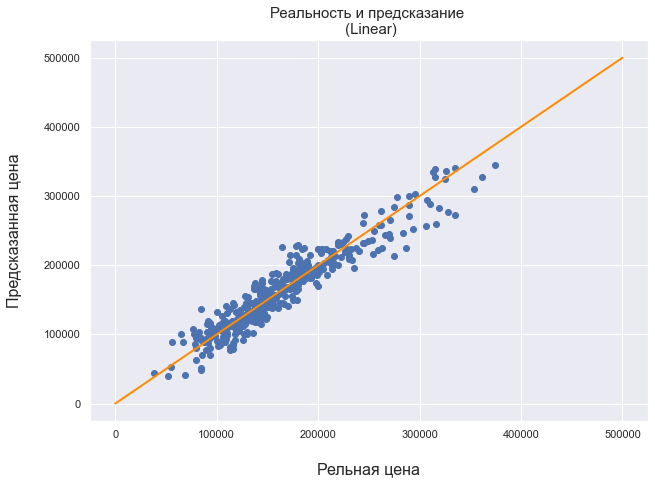

In [74]:
plt.figure()
plt.title("Реальность и предсказание \n (Linear)", fontsize=15)
plt.scatter(y_test, y_pred_l, marker="o")
plt.plot([0, 500000], [0, 500000], "darkorange", lw=2)
plt.xlabel("\nРельная цена", fontsize=16)
plt.ylabel("Предсказанная цена\n", fontsize=16)
plt.show()

Проверим регрессию по методу Лассо (Lasso Regression) c l1 регуляризацией.

In [75]:
model_lasso = linear_model.Lasso(alpha=21)
model_lasso.fit(X_train, y_train)
y_pred_lasso = model_lasso.predict(X_test)
print_score(y_test, y_pred_lasso, "Lasso")

Модель: Lasso
R² = 0.9006392800772891
RMSE = 18564.75528202409


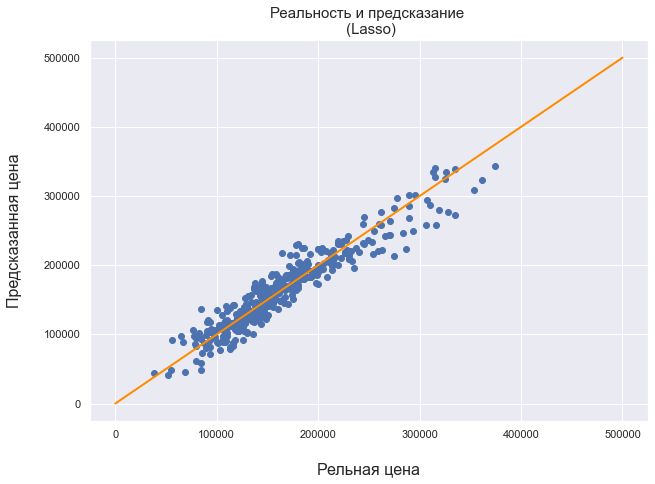

In [76]:
plt.figure()
plt.title("Реальность и предсказание \n (Lasso)", fontsize=15)
plt.scatter(y_test, y_pred_lasso, marker="o")
plt.plot([0, 500000], [0, 500000], "darkorange", lw=2)
plt.xlabel("\nРельная цена", fontsize=16)
plt.ylabel("Предсказанная цена\n", fontsize=16)
plt.show()

Проверим Ridge Regression c l2 регуляризацией.

In [77]:
model_ridge = linear_model.Ridge(alpha=1.7)
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)
print_score(y_test, y_pred_ridge, "Ridge")

Модель: Ridge
R² = 0.9005804543103793
RMSE = 18570.250030730207


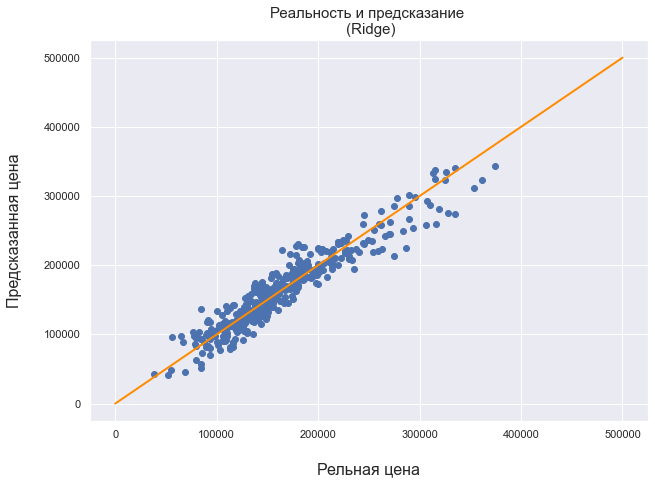

In [78]:
plt.figure()
plt.title("Реальность и предсказание \n (Ridge)", fontsize=15)
plt.scatter(y_test, y_pred_ridge, marker="o")
plt.plot([0, 500000], [0, 500000], "darkorange", lw=2)
plt.xlabel("\nРельная цена", fontsize=16)
plt.ylabel("Предсказанная цена\n", fontsize=16)
plt.show()

Рассмотрим дерово решений.С учетом небольших данных некоторые параметры модели (max_depth, min_samples_split) подбирались вручную.

In [79]:
decision_tree_model = DecisionTreeRegressor(random_state=0, max_depth=4, min_samples_split=60)
decision_tree_model.fit(X_train, y_train)
y_pred_decision_tree = decision_tree_model.predict(X_test)
print_score(y_test, y_pred_decision_tree, "Decision Tree")

Модель: Decision Tree
R² = 0.750403003009145
RMSE = 29423.988485941645


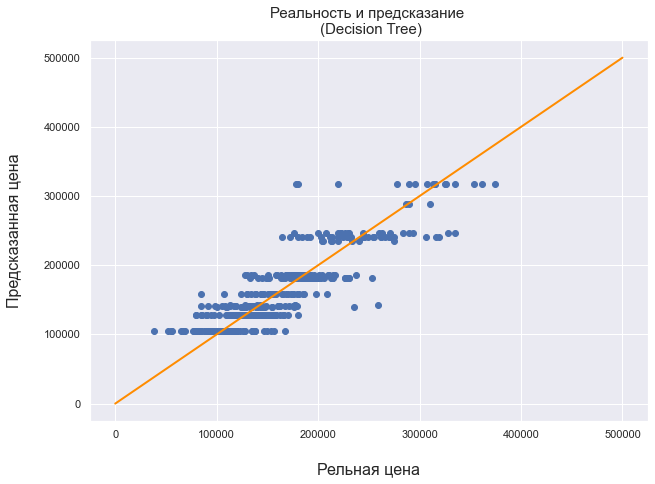

In [80]:
plt.figure()
plt.title("Реальность и предсказание \n (Decision Tree)", fontsize=15)
plt.scatter(y_test, y_pred_decision_tree, marker="o")
plt.plot([0, 500000], [0, 500000], "darkorange", lw=2)
plt.xlabel("\nРельная цена", fontsize=16)
plt.ylabel("Предсказанная цена\n", fontsize=16)
plt.show()

Как известно, дерево решений не всегда показывает хорошие результаты, поэтому воспользуемся Random Forest.

In [81]:
model_random_forest = RandomForestRegressor(random_state=0)
model_random_forest.fit(X_train, y_train)
y_pred_random_forest = model_random_forest.predict(X_test)
print_score(y_test, y_pred_random_forest, "Random Forest")

Модель: Random Forest
R² = 0.8904783036434016
RMSE = 19490.902318139502


Займемся настройкой параметров Random Forest при помощи GridSearchCV.

In [82]:
model_random_forest_reg = RandomForestRegressor(random_state=0)
parameters = {'n_estimators': range(1, 201, 50), 'max_depth':range(1, 101, 50), 'min_samples_split':range(2, 102, 50)}

In [83]:
grid_search_cv_reg = GridSearchCV(model_random_forest_reg, parameters, cv=5)

In [84]:
grid_search_cv_reg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': range(1, 101, 50),
                         'min_samples_split': range(2, 102, 50),
                         'n_estimators': range(1, 201, 50)})

In [85]:
grid_search_cv_reg.best_params_

{'max_depth': 51, 'min_samples_split': 2, 'n_estimators': 151}

In [86]:
model_random_forest = RandomForestRegressor(random_state=0, max_depth=51, min_samples_split=2, n_estimators=151)
model_random_forest.fit(X_train, y_train)
y_pred_random_forest = model_random_forest.predict(X_test)
print_score(y_test, y_pred_random_forest, "Random Forest")

Модель: Random Forest
R² = 0.8897941247038609
RMSE = 19551.68709350206


XGBoost Regression

In [100]:
#model_gradient_boosting_reg = GradientBoostingRegressor()
#parameters_xq = {'min_samples_split':range(2, 102, 50),
#                 'n_estimators': range(500, 5001, 500)}
#grid_search_cv_reg_xq = GridSearchCV(model_gradient_boosting_reg, parameters_xq, cv=5)
#grid_search_cv_reg_xq.fit(X_train, y_train)
#print(grid_search_cv_reg_xq.best_params_)

In [101]:
model_xgb = GradientBoostingRegressor(max_depth=1, min_samples_split=2, n_estimators=2000)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)
print_score(y_test, y_pred_xgb, "GBoost Regression")

Модель: GBoost Regression
R² = 0.9103773082055743
RMSE = 17631.5647291889


Модель GradientBoostingRegressor вернула лучшее значение R² с точностью 91,04% и с наименьшим отклонением. Поэтому для прогнозирования цены булем использовать данную модель.

In [102]:
y_pred = model_xgb.predict(finish_test)

output = pd.DataFrame({"Id": list_id_test, "SalePrice": y_pred})

output.head(10)

,Id,SalePrice
0,1461,"159,528.43"
1,1462,"188,665.63"
2,1463,"201,633.48"
3,1464,"210,991.86"
4,1465,"199,342.09"
5,1466,"200,472.95"
6,1467,"193,946.12"
7,1468,"183,747.47"
8,1469,"186,812.13"
9,1470,"165,861.14"


In [103]:
output.to_csv("submission.csv", index=False)